In [153]:
%pylab inline
import pandas as pd
import numpy as np
import scanpy as sc

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='inferno')
sc.logging.print_header()

Populating the interactive namespace from numpy and matplotlib
scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.2


This script is adapted from Valentin Svensson blog post on logistic regression https://www.nxn.se/. 

Note, this is an examle of logistic regression trained on the epithelial cells alone (excluding mesenchymal and neuronal subtypes). The results support the conclusion that the in vitro maturation of the epithelium in culture. 

Load the test dataset 

In [116]:
org_V3 = sc.read('/mnt/Dec2020/fetal_organoidp1p17_normalised.h5ad')

In [14]:
obs[0]

0       AAACCTGAGATATGCA-1-4918STDY7426910
1       AAACCTGAGTGAAGTT-1-4918STDY7426910
2       AAACCTGCAATAAGCA-1-4918STDY7426910
3       AAACCTGGTAAACGCG-1-4918STDY7426910
4       AAACCTGGTACGACCC-1-4918STDY7426910
                       ...                
9257    TTTGGTTCAGGTCGTC-1-4918STDY7590325
9258    TTTGGTTTCTCCCTGA-1-4918STDY7590325
9259    TTTGGTTTCTTCAACT-1-4918STDY7590325
9260    TTTGTCAAGTGGTAAT-1-4918STDY7590325
9261    TTTGTCAGTCTTCTCG-1-4918STDY7590325
Name: 0, Length: 9262, dtype: object

In [6]:
#Prepare a pandas dataframe with normalised, log transformed counts. 

In [15]:
pV3 = pd.DataFrame(org_V3.raw.X.todense())
pV3.columns = org_V3.raw.var.index
obs = pd.DataFrame(org_V3.obs.index)
pV3.index = obs[0].values
pV3

,RP11-34P13.7,FO538757.2,AP006222.2,RP4-669L17.10,RP5-857K21.4,RP11-206L10.4,RP11-206L10.9,LINC00115,FAM41C,RP11-54O7.1,...,BX004987.4,AC145212.4,AC145212.2,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AL354822.1,AC004556.1,AC240274.1
AAACCTGAGATATGCA-1-4918STDY7426910,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.736500,0.0,0.0,0.0,0.0,0.0,0.000000
AAACCTGAGTGAAGTT-1-4918STDY7426910,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
AAACCTGCAATAAGCA-1-4918STDY7426910,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
AAACCTGGTAAACGCG-1-4918STDY7426910,0.0,0.000000,0.659822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
AAACCTGGTACGACCC-1-4918STDY7426910,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGGTCGTC-1-4918STDY7590325,0.0,0.000000,0.313646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
TTTGGTTTCTCCCTGA-1-4918STDY7590325,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
TTTGGTTTCTTCAACT-1-4918STDY7590325,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.253273,0.0,0.0,0.0,0.0,0.0,0.000000
TTTGTCAAGTGGTAAT-1-4918STDY7590325,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.312717,0.0,0.0,0.0,0.0,0.0,0.000000


In [16]:
pV3.shape

(9262, 19438)

In [8]:
#Load the training dataset

In [21]:
fetal_V120 = sc.read("/mnt/PROJECTS/Revisions_DevCell/final_fetal_object_cellxgene.h5ad")

In [24]:
list(fetal_V120.obs.cell_name_detailed.unique())

['Mesoderm 1',
 'WNT4+ fibroblasts',
 'Immune cells',
 'Smooth muscle cells',
 'Erythroblasts',
 'Mesoderm 2',
 'Neural crest cells',
 'Enteric neurons',
 'Uniform progenitors',
 'Serosa/mesothelial cells',
 'Pericyte',
 'Venous endothelial cell',
 'FOXL1+ fibroblasts',
 'Arterial endothelial cell',
 'Lymphatic endothelial cell',
 'Myofibroblast',
 'Enterocytes',
 'FRZB+ fibroblasts',
 'Colonocytes',
 'Interstitial cells of Cajal',
 'BEST4+ enterocyte',
 'Enteroendocrine',
 'Enterocyte',
 'G2M/S enterocytes',
 'Goblet',
 'Early enterocyte',
 'LGR5 stem',
 'NTS+ epithelial cells']

In [11]:
#Create a pandas dataframe of training dataset

In [41]:
sub_train = fetal_V120[fetal_V120.obs.cell_name_detailed.isin([
 'BEST4+ enterocyte',
 'Enteroendocrine',
 'Enterocyte',
 'G2M/S enterocytes',
 'Goblet',
 'Early enterocyte',
 'LGR5 stem',
 'NTS+ epithelial cells','Uniform progenitors'])]

In [42]:
pV2 = pd.DataFrame(sub_train.X.todense())
pV2.columns = sub_train.var.index
obsV2 = pd.DataFrame(sub_train.obs.index)
pV2.index = obsV2["index"].values
pV2

index,RP11-34P13.7,RP11-34P13.8,FO538757.3,FO538757.2,AP006222.2,RP4-669L17.10,RP5-857K21.4,RP11-206L10.4,RP11-206L10.9,FAM87B,...,BX004987.4,AC145212.4,AC145212.2,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AL354822.1,AC004556.1,AC240274.1
AACTGGTGTAAGTTCC-1-4918STDY7321513,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.022448,0.000000
AAGTCTGCAGTCCTTC-1-4918STDY7321513,0.0,0.0,0.0,0.416723,0.000000,0.709988,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.936465,0.000000
ACACCCTAGTTAGGTA-1-4918STDY7321513,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
ACGCAGCAGTAGGCCA-1-4918STDY7321513,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.309458,0.000000
ACTGTCCGTGTAATGA-1-4918STDY7321513,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GACCAATAGAGGTTAT-1-4918STDY7718977,0.0,0.0,0.0,0.000000,0.100843,0.000000,0.0,0.0,0.100843,0.0,...,0.0,0.0,0.0,0.353759,0.0,0.100843,0.0,0.0,0.670353,0.000000
GATGAGGTCCGGCACA-1-4918STDY7718977,0.0,0.0,0.0,0.364163,0.256867,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.256867,0.0,0.136658,0.0,0.0,0.630537,0.000000
TCGGGACAGAGCTATA-1-4918STDY7718977,0.0,0.0,0.0,0.190854,0.190854,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.099973,0.0,0.190854,0.0,0.0,0.816115,0.000000
TGGGAAGCAACGATCT-1-4918STDY7718977,0.0,0.0,0.0,0.546115,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.897339,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [18]:
#Unite training and test dataset on common genes

In [43]:
organoid = pV3.loc[:,pV3.columns.isin(pV2.columns)]

In [44]:
fetal_train = pV2.loc[:,pV2.columns.isin(organoid.columns)]

In [45]:
fetal_train.shape

(14490, 19379)

In [46]:
organoid.shape

(9262, 19379)

In [48]:
#Save the training dataset metadata.
s_sample_info = sub_train.obs[sub_train.obs_names.isin(sub_train.obs_names)]
s_sample_info.head(2)

,CRL,Enrichment_fraction,PCW,Donor_nb,Donor_id,Purification,Organ,Sample,doublet_scores_observed_cells,n_genes,percent_mito,n_counts,cell_type_group,cell_name,cell_name_detailed
index,,,,,,,,,,,,,,,
AACTGGTGTAAGTTCC-1-4918STDY7321513,17,pos,F6.1,1,2029,none,duojejunum,4918STDY7321513,0.076267,1655,0.07120,5618.0,epithelium,Uniform progenitors,Uniform progenitors
AAGTCTGCAGTCCTTC-1-4918STDY7321513,17,pos,F6.1,1,2029,none,duojejunum,4918STDY7321513,0.078565,3914,0.04627,19343.0,epithelium,Uniform progenitors,Uniform progenitors


In [49]:
s_sample_info.cell_name_detailed.value_counts()

Early enterocyte         4157
G2M/S enterocytes        3935
Uniform progenitors      2659
Enterocyte               1586
LGR5 stem                1001
Goblet                    504
Enteroendocrine           383
NTS+ epithelial cells     182
BEST4+ enterocyte          83
Name: cell_name_detailed, dtype: int64

In [50]:
#split the training dataset to train and test datasets

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(fetal_train, s_sample_info['cell_name_detailed'], 
                                                    test_size=.1,stratify =s_sample_info['cell_name_detailed'])

In [53]:
pd.value_counts(y_test)

Early enterocyte         416
G2M/S enterocytes        394
Uniform progenitors      266
Enterocyte               159
LGR5 stem                100
Goblet                    50
Enteroendocrine           38
NTS+ epithelial cells     18
BEST4+ enterocyte          8
Name: cell_name_detailed, dtype: int64

In [54]:
#train the model. Change the C value and penalty as per dataset

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
lr = LogisticRegression(C=0.2, penalty='l1', solver='saga', n_jobs=-1)

In [57]:
lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.2, n_jobs=-1, penalty='l1', solver='saga')

In [58]:
lr.classes_

array(['BEST4+ enterocyte', 'Early enterocyte', 'Enterocyte',
       'Enteroendocrine', 'G2M/S enterocytes', 'Goblet', 'LGR5 stem',
       'NTS+ epithelial cells', 'Uniform progenitors'], dtype=object)

In [59]:
lr.coef_.shape

(9, 19379)

In [60]:
y_hat = lr.predict(X_train)

In [61]:
y_hat

array(['Enterocyte', 'G2M/S enterocytes', 'G2M/S enterocytes', ...,
       'Enterocyte', 'LGR5 stem', 'Enterocyte'], dtype=object)

In [62]:
lr.score(X_train, y_train)

0.9723947550034506

In [63]:
from sklearn import metrics

In [64]:
#If majority of the cells are classified as one class, I am happy. 

In [65]:
pd.DataFrame.from_records(metrics.confusion_matrix(y_train, y_hat), index=lr.classes_)

,0,1,2,3,4,5,6,7,8
BEST4+ enterocyte,58,7,3,4,1,1,0,1,0
Early enterocyte,0,3694,16,0,17,1,2,3,8
Enterocyte,0,23,1404,0,0,0,0,0,0
Enteroendocrine,1,5,0,290,15,9,14,0,11
G2M/S enterocytes,1,17,0,1,3486,8,8,1,19
Goblet,1,0,0,4,12,428,9,0,0
LGR5 stem,0,3,0,1,17,8,865,0,7
NTS+ epithelial cells,0,7,0,0,0,1,2,147,7
Uniform progenitors,0,24,0,1,36,2,21,0,2309


In [66]:
sparsity = np.mean(lr.coef_.ravel() == 0) * 100
sparsity

94.77785231436091

In [67]:
#Check top marker genes

In [68]:
marker_genes = pd.DataFrame({
    'cell_type': lr.classes_[lr.coef_.argmax(0)],
    'gene': X_train.columns,
    'weight': lr.coef_.max(0)
})

In [69]:
marker_genes.query('weight > 0.').shape


(3439, 3)

In [70]:
top_markers = \
marker_genes \
    .query('weight > 0.') \
    .sort_values('weight', ascending=False) \
    .groupby('cell_type') \
    .head(100) \
    .sort_values(['cell_type', 'weight'], ascending=[True, False])

In [71]:
top_markers.head(5)

,cell_type,gene,weight
578,BEST4+ enterocyte,GUCA2B,0.605960
18405,BEST4+ enterocyte,SPIB,0.453735
579,BEST4+ enterocyte,GUCA2A,0.410299
1235,BEST4+ enterocyte,S100A6,0.374727
14955,BEST4+ enterocyte,CA7,0.357127


In [58]:
#top_markers.to_csv("/mnt/Dec2020/organoidp1p17_topmarkers.csv")

In [72]:
#Plot top marker genes if needed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  del sys.path[0]


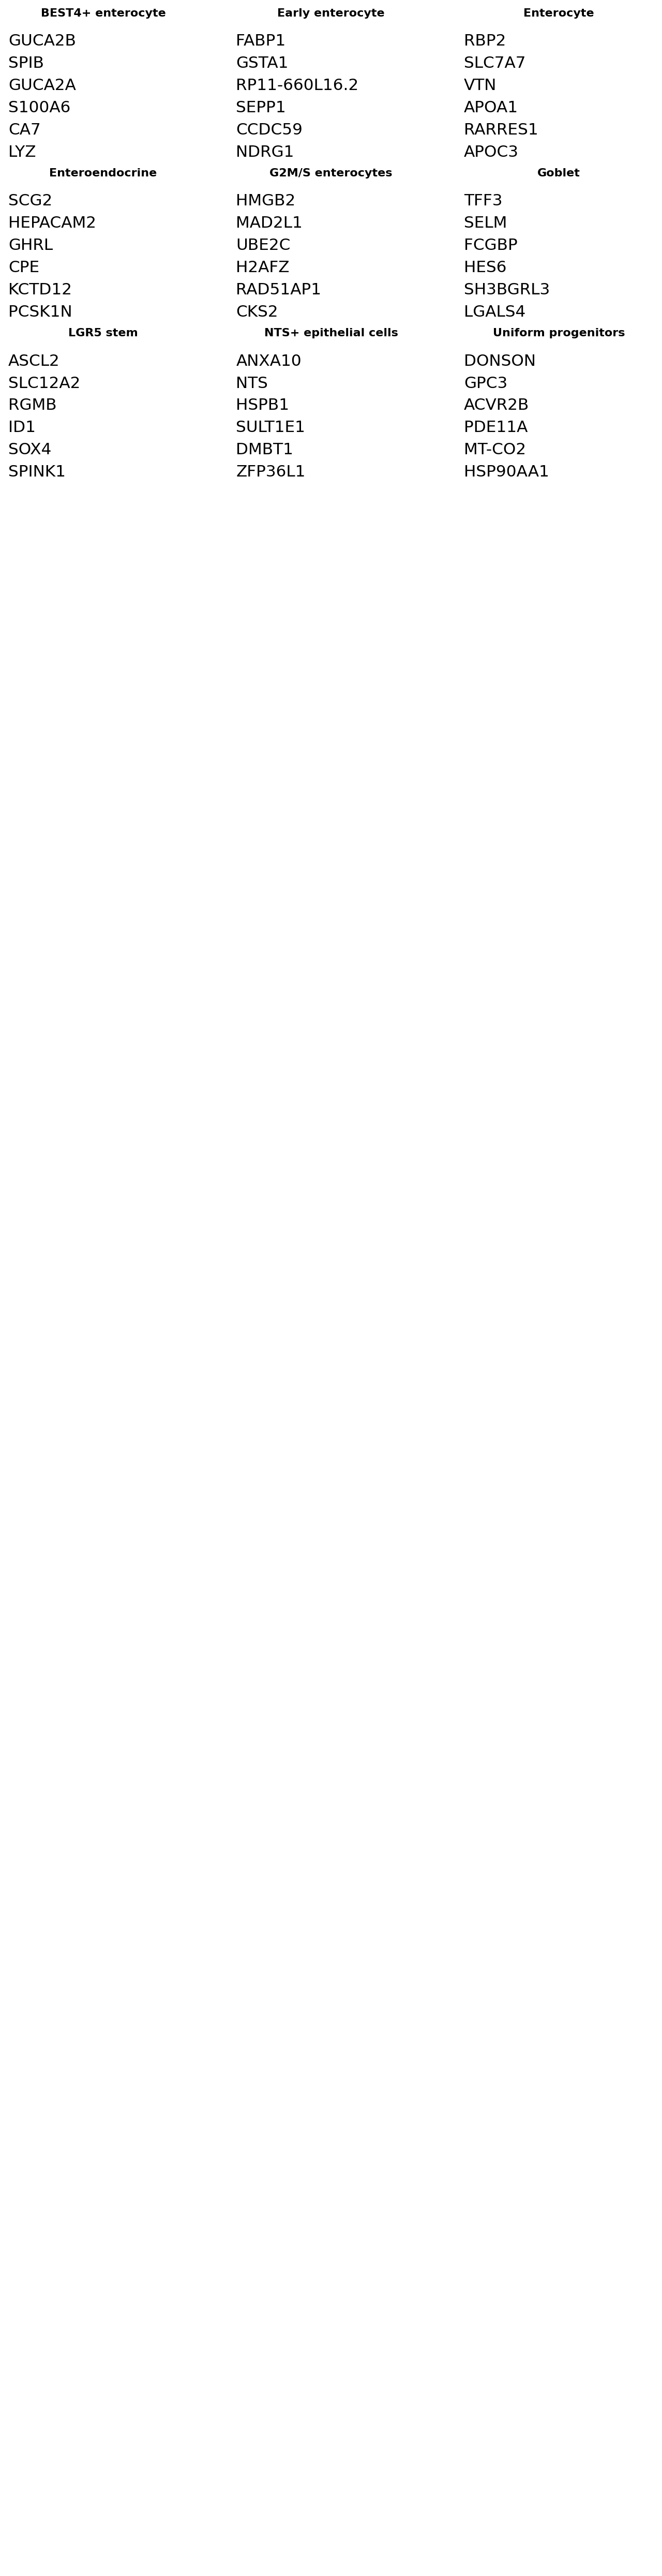

In [72]:
import matplotlib.pyplot as plt
figsize(10, 25)
for i, m in enumerate(top_markers.cell_type.unique()):
    plt.subplot(10, 3, i + 1)
    g = top_markers.query('cell_type == @m')
    plt.title(m, size=10, weight='bold')
    for j, gn in enumerate(g.gene):
        plt.annotate(gn, (0, 0.2* j), )
        
    plt.axis('off')
    plt.ylim(10 * 0.1, -0.2)
    
plt.tight_layout()
#plt.savefig('/mnt/PROJECTS/Fetal_paper/log_reg_genes.pdf', bbox_inches='tight')

In [73]:
shift_idx = y_train.argsort()
sorted_idx = y_train.sort_values().index

In [74]:
y_prob = lr.predict_log_proba(X_train.loc[sorted_idx])

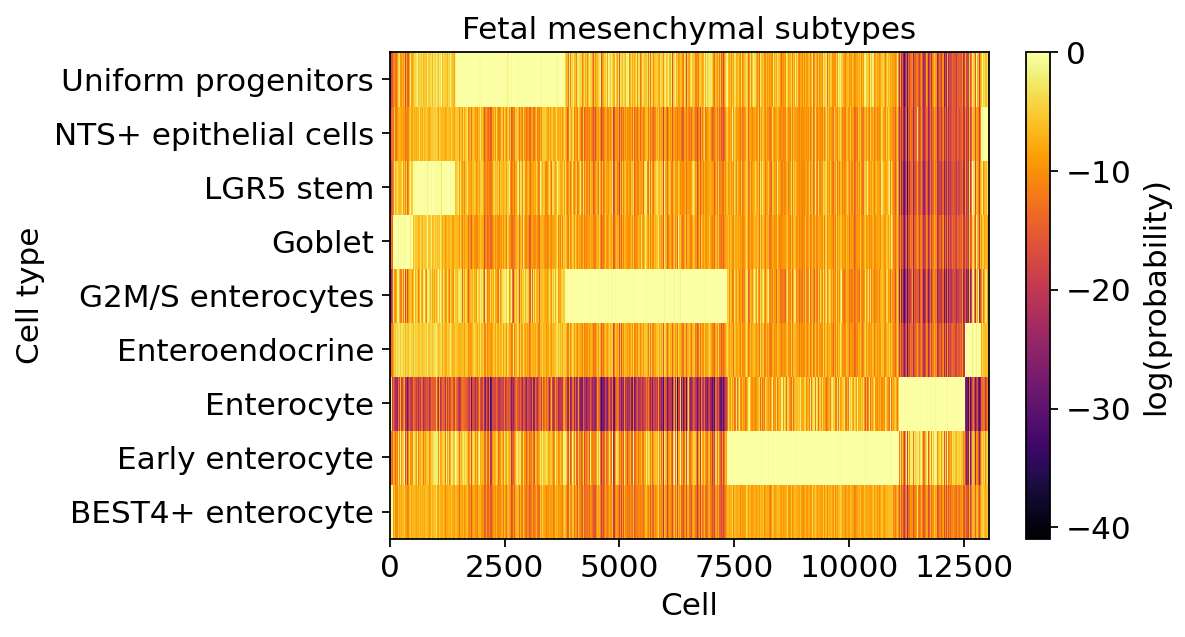

In [75]:
import matplotlib.pyplot as plt
figsize(6, 4)
plt.pcolor(y_prob.T, vmax=0)
plt.yticks(0.5 + np.arange(lr.classes_.shape[0]), lr.classes_);
plt.colorbar(label='log(probability)');
plt.ylabel('Cell type')
plt.xlabel('Cell');
plt.title('Fetal mesenchymal subtypes');
#plt.savefig('/mnt/PROJECTS/Fetal_paper/subtypes.pdf', dpi=None, facecolor='w', edgecolor='w',
#        orientation='portrait', papertype=None, format=None,
#        transparent=False, pad_inches=0.1,
#        frameon=None, bbox_inches='tight')

In [80]:
#Predict test training data

In [76]:
set(lr.classes_) - set(np.unique(lr.classes_[y_prob.argmax(1)]))

set()

In [77]:
predictions = lr.predict(X_test)
predictions_prob = lr.predict_proba(X_test)

In [78]:
pd.DataFrame.from_records(metrics.confusion_matrix(y_test, predictions), index=lr.classes_ )

,0,1,2,3,4,5,6,7,8
BEST4+ enterocyte,7,0,0,0,0,0,0,1,0
Early enterocyte,0,376,13,0,6,0,8,1,12
Enterocyte,0,15,144,0,0,0,0,0,0
Enteroendocrine,0,4,0,26,4,1,2,0,1
G2M/S enterocytes,0,16,0,0,357,1,4,0,16
Goblet,0,1,0,2,7,36,3,0,1
LGR5 stem,0,5,0,0,4,3,86,0,2
NTS+ epithelial cells,1,3,0,0,0,0,0,11,3
Uniform progenitors,0,12,0,0,21,1,5,0,227


### Evaluate the model using test fetal data 

In [79]:
from sklearn import metrics
from scanpy.plotting.palettes import *

cmap = ["#2E9FDF", "#00AFBB", "#E7B800", "#FC4E07",'#5254a3',
 '#6b6ecf','#9c9ede','#9c9ede', '#637939', '#8ca252','#8ca252','#b5cf6b',
 '#cedb9c', '#8c6d31', '#bd9e39','#e7ba52']

def plot_roc(y_prob, y_test, lr):
    aucs =[]
    if len(lr.classes_)<21: colors = cmap
    elif len(lr.classes_)<27: colors = cmap
    else: colors = cmap
    for i, cell_type in enumerate(lr.classes_):
        fpr, tpr, _ = metrics.roc_curve(y_test == cell_type, y_prob[:, i])
        auc = metrics.auc(fpr, tpr)
        aucs.append(auc)
        plt.plot(fpr, tpr, c=colors[i], lw=2, label = cell_type)
    plt.plot([0, 1], [0, 1], color='k', ls=':')
    plt.legend(loc=(1.02,0))
    min_auc = np.min(aucs)
    plt.title("Min AUC: %.3f"%(min_auc))
    return(min_auc)
    plt.grid(None)
#    plt.savefig('/mnt/PROJECTS/Fetal_paper/ROC.pdf')

0.9994218653264868

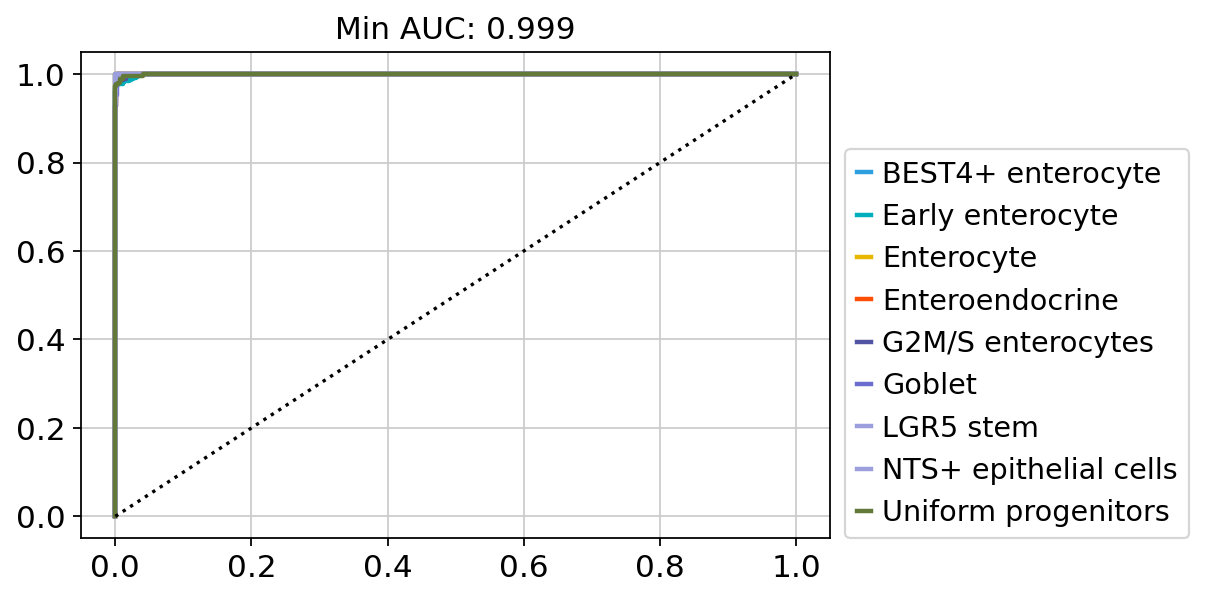

In [80]:
import matplotlib.pyplot as plt
figsize(6, 4)
plot_roc(predictions_prob,predictions,lr)
#plt.savefig('/mnt/PROJECTS/Fetal_paper/ROC.pdf', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

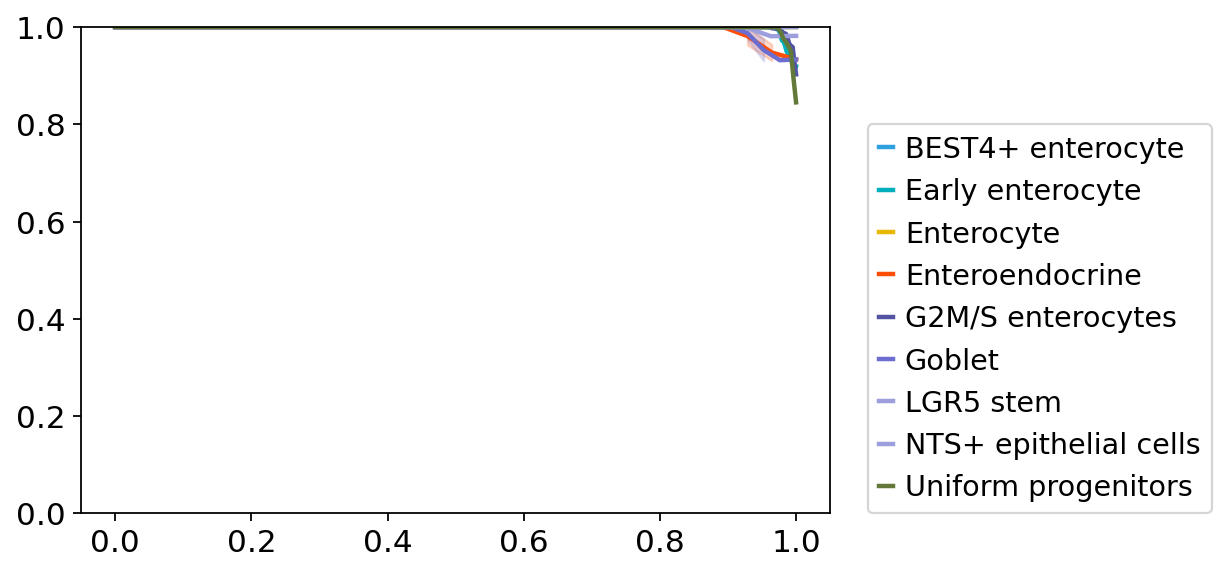

In [83]:
if len(lr.classes_)<21: colors = cmap
elif len(lr.classes_)<27: colors = cmap
else: colors = cmap
for i, cell_type in enumerate(lr.classes_):
    precision, recall, _ = metrics.precision_recall_curve(predictions == cell_type, predictions_prob[:, i])
    sns.lineplot(recall, precision, color=colors[i], lw=2, label = cell_type)
    plt.ylim(0, 1)
    plt.legend(loc=(1.05,0))
    plt.grid(None)
    #plt.savefig('/mnt/PROJECTS/Fetal_paper/Precision_recall.pdf', bbox_inches='tight')

PRC 

### Use the model to make the predictions on data  

In [143]:
x_test = organoid
print(x_test.iloc[0:4,0:4])
predictions = lr.predict(x_test)
predictions_prob = lr.predict_proba(x_test)

df = pd.DataFrame(x_test.index)
df1 = pd.DataFrame(predictions)
df2 = pd.DataFrame(predictions_prob, columns=lr.classes_)
label1 = df.merge(df1,left_index=True,right_index=True, how = 'outer')
label2 = label1.merge(df2,left_index=True,right_index=True, how = 'outer')

label2.loc[df2.apply(max, axis = 1)<0.6,"0_y"]="NAN"


                                    RP11-34P13.7  FO538757.2  AP006222.2  \
AAACCTGAGATATGCA-1-4918STDY7426910           0.0         0.0    0.000000   
AAACCTGAGTGAAGTT-1-4918STDY7426910           0.0         0.0    0.000000   
AAACCTGCAATAAGCA-1-4918STDY7426910           0.0         0.0    0.000000   
AAACCTGGTAAACGCG-1-4918STDY7426910           0.0         0.0    0.659822   

                                    RP4-669L17.10  
AAACCTGAGATATGCA-1-4918STDY7426910            0.0  
AAACCTGAGTGAAGTT-1-4918STDY7426910            0.0  
AAACCTGCAATAAGCA-1-4918STDY7426910            0.0  
AAACCTGGTAAACGCG-1-4918STDY7426910            0.0  


In [144]:
org_V3 = sc.read('/mnt/Dec2020/fetal_organoidp1p17_normalised.h5ad')
label2.index = label2["0_x"]
df = pd.DataFrame(org_V3.obs)
label2 = pd.merge(label2, df, left_index=True, right_index=True)

In [145]:
org_V3.obs = label2

... storing '0_y' as categorical


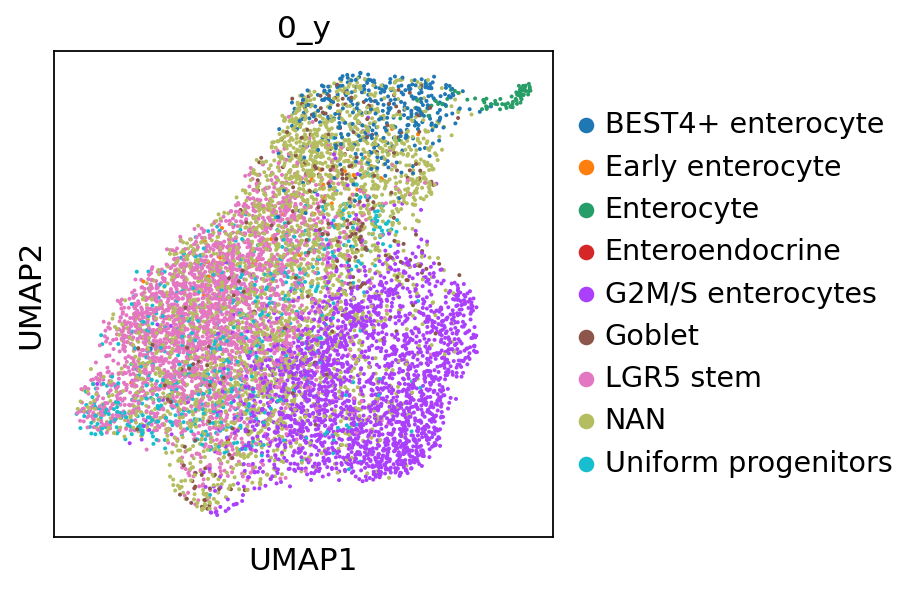

In [146]:
sc.pl.umap(org_V3, color="0_y")

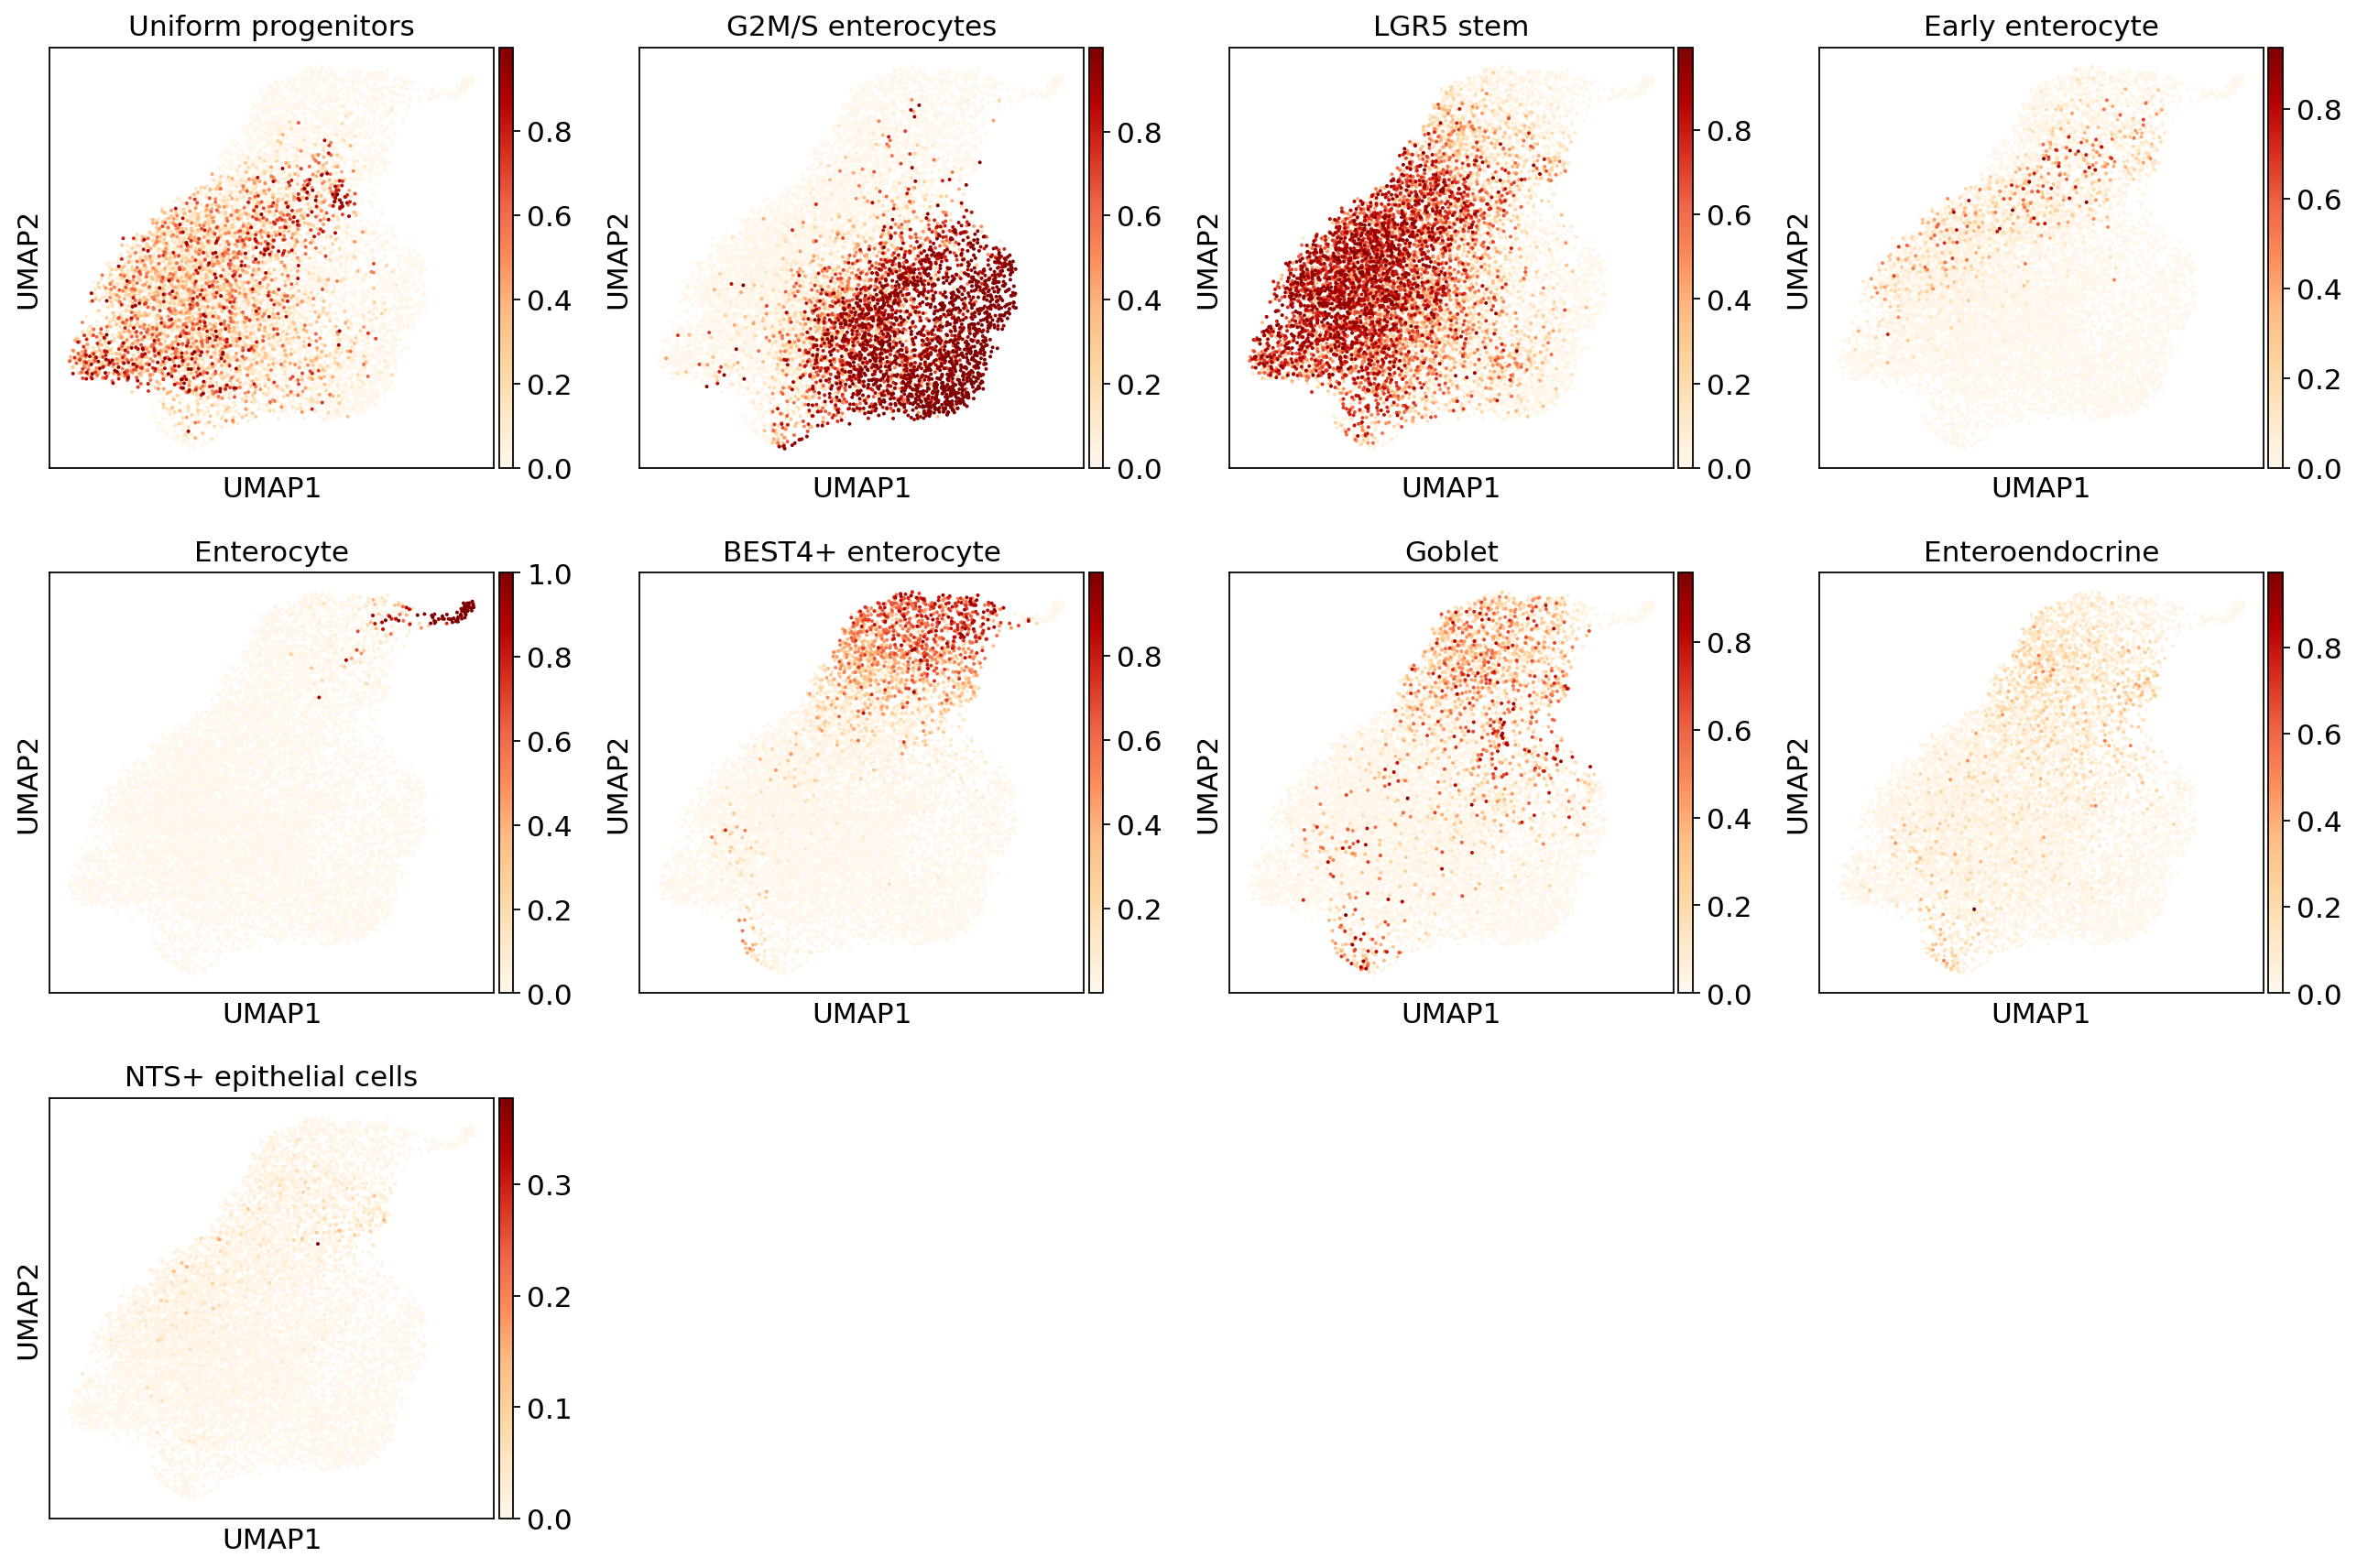

In [147]:
sc.pl.umap(org_V3, color=['Uniform progenitors', 'G2M/S enterocytes',  'LGR5 stem','Early enterocyte', 'Enterocyte',
             'BEST4+ enterocyte', 'Goblet','Enteroendocrine','NTS+ epithelial cells'], cmap="OrRd")

NTS+ cells, Enteroendocrine cells and some Uniform frogenitors are predicted with less than 80% probability. 

In [101]:
label2.to_csv("/mnt/Dec2020/label2_automated_p1p17.csv")

In [148]:
#I will plot the changes in cell type composition in P1 vs P17
cell = pd.crosstab(index=org_V3.obs.Condition, 
                           columns=org_V3.obs["0_y"])

In [149]:
cell.columns

CategoricalIndex(['BEST4+ enterocyte', 'Early enterocyte', 'Enterocyte',
                  'Enteroendocrine', 'G2M/S enterocytes', 'Goblet',
                  'LGR5 stem', 'NAN', 'Uniform progenitors'],
                 categories=['BEST4+ enterocyte', 'Early enterocyte', 'Enterocyte', 'Enteroendocrine', 'G2M/S enterocytes', 'Goblet', 'LGR5 stem', 'NAN', ...], ordered=False, name='0_y', dtype='category')

In [150]:
cell.columns = ['BEST4+ enterocyte', 'Early enterocyte', 'Enterocyte',
                  'Enteroendocrine', 'G2M/S enterocytes', 'Goblet',
                  'LGR5 stem', 'NAN', 'Uniform progenitors']
cell["Pred"]=cell.index
cell_raw=pd.melt(cell, id_vars=['Pred'])
result = cell_raw.pivot(index='variable', columns='Pred', values='value')

In [151]:
epi_result = result.T
cols = list(epi_result.columns)
epi_result[cols] =epi_result[cols].div(epi_result[cols].sum(axis=1), axis=0).multiply(100)

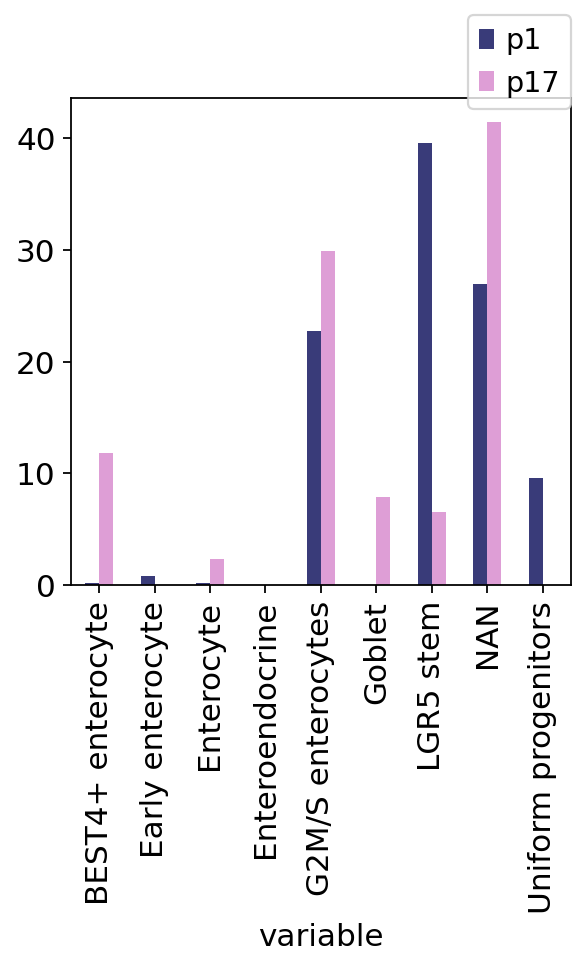

In [152]:
ax = epi_result.transpose().plot.bar(rot=90, color = {"p1" : '#393b79', "p17" : '#de9ed6'})
horiz_offset = 1.03
vert_offset = 1.2
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
ax.grid(None)

## END